## 电商评论词云
将电商评论分别按品牌和平台显示词云


In [1]:
import pandas as pd

import numpy as np
from scipy.stats import multivariate_normal
from sklearn.mixture import GaussianMixture
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import pairwise_distances_argmin

from wordcloud import WordCloud
from matplotlib import font_manager

from IPython.display import display, HTML
import matplotlib as mpl 
from matplotlib.font_manager import *    
import seaborn as sns
sns.set_style("whitegrid")

from itertools import cycle, islice

title_fsize = 15
brand_colors  = ['blue', 'darkorange', 'grey', 'yellow']
store_colors = ['red', 'purple', 'green']
%matplotlib inline
mpl.style.use('default')
#指定默认字体  
myfont = FontProperties(fname="C:\Windows\Fonts\msyh.ttc")  


In [31]:
## 读文件
brands = ['tissot','fiyta','casio','longines']
brand_index = ['TISSOT', 'FIYTA', 'CASIO', 'LONGINES']
cols = ['brand','cat','setiment','reviews','date','time','platform','url']
df_ec_reviews = None

for b_ in brands:
    print(b_)
    df_review = pd.read_excel("../data/201804/Tissot KiSS_Data comment20180301-20180331.xlsx",b_, parse_cols="A:H", names=cols)
    
    print(df_review.shape)
    df_ec_reviews = pd.concat([df_ec_reviews,df_review], axis =0)
#     print(df_ec_reviews.shape)

df_ec_reviews = df_ec_reviews.dropna(axis=1, how='all')
## fix data error
df_ec_reviews.brand = df_ec_reviews.brand.str.upper()
df_ec_reviews.head() 


tissot
(2121, 8)
fiyta
(1218, 8)
casio
(7973, 8)
longines
(499, 8)


,brand,cat,setiment,reviews,date,time,platform,url
0,TISSOT,设计,0,应该是正品无疑，从包装到表，都没问题，保修卡也对，支持关注，有好货就拿下,2018-03-01,00:16:25,tmall,https://detail.tmall.com/item.htm?id=449075823...
1,TISSOT,质量,1,第五次购买了 给朋友生日买的 他们窦很喜欢 正品 价格便宜,2018-03-01,00:50:11,tmall,https://detail.tmall.com/item.htm?id=406047765...
2,TISSOT,质量,1,宝贝昨天到的，忙到现在来评价，带了一天，没误差，感觉不错！,2018-03-01,00:51:01,tmall,https://detail.tmall.com/item.htm?id=400342420...
3,TISSOT,外观,1,质量挺不错的，高端大气上档次，款式很好看，很喜欢,2018-03-01,03:05:00,taobao,https://item.taobao.com/item.htm?id=5632419754...
4,TISSOT,服务,1,宝贝超喜欢呢！客服服务也棒棒哒，喜欢！,2018-03-01,04:14:04,tmall,https://detail.tmall.com/item.htm?id=410966744...


In [32]:
df_ec_reviews.brand.unique()

array(['TISSOT', 'FIYTA', 'CASIO', 'LONGINES'], dtype=object)

In [33]:
# drop duplicate
df_ec_reviews = df_ec_reviews.drop_duplicates(['brand','reviews'])
df_ec_reviews.groupby(['brand','platform'])['time'].count()

brand     platform
CASIO     taobao      2076
          tmall       5897
FIYTA     taobao       127
          tmall       1091
LONGINES  taobao       251
          tmall        248
TISSOT    taobao      1065
          tmall       1056
Name: time, dtype: int64

In [34]:
# 对广告位描述分词
from sklearn import feature_extraction
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
import jieba
import jieba.analyse as jieba_analyse
import jieba.posseg as pseg

jieba_analyse.set_stop_words('stopwords.txt') 
jieba.load_userdict('userdict.txt')

# jieba.add_word('中大型')
datas = []

df_wcut = df_ec_reviews['reviews']
corpus = df_wcut.values
for oneline in corpus:
    seg_list = pseg.cut(oneline)
#     print([",".join(w) for w in seg_list ])
    words = [w for w,c in seg_list if c not in ['v','x','f','d','p'] and len(w)>1 and not w.isnumeric()]
    
    datas.append(" ".join(words))
datas[-5:]

['简洁 大方 优雅 本质 表面 粉色 珍珠 贝母 女人 味十足 机械表 嘉岚 石英表 这个 机械表 证明 自己 专柜 真假 自己 表带 既然 正品 发货 和顺 丰都 时间',
 '物流 还是',
 '东西 手表 正品 而且 实体店 优惠 很多',
 '手表 检查 每天 误差 天梭差 客气 表带 黑色 黑色 棕色 态度',
 '不错 服务态度 唯一 不足 发货 现货 货后 一个月 发票 时间']

In [35]:
# 计算tfidf
freWord = CountVectorizer()
#统计每个词语的tf-idf权值
transformer = TfidfTransformer()
#计算出tf-idf(第一个fit_transform),并将其转换为tf-idf矩阵(第二个fit_transformer)
tfidf = transformer.fit_transform(freWord.fit_transform(datas))

#获取词袋模型中的所有词语
word = freWord.get_feature_names()
#得到权重
weight = tfidf.toarray()
tfidfDict = {}
for i in range(len(weight)):
    for j in range(len(word)):
        getWord = word[j]
        
        getValue = weight[i][j]
        
        if getValue != 0:
            if tfidfDict.get(getWord):
                tfidfDict[getWord] += getValue
                
            else:
                tfidfDict.update({getWord:getValue})

In [36]:
# tfidf 排序
sorted_tfidf = sorted(tfidfDict.items(),key = lambda d:d[1],reverse = True)
print('Top 20 relative Keywords:')
sorted_tfidf[:60]

Top 20 relative Keywords:


[('不错', 776.40650330985),
 ('手表', 705.9250104070136),
 ('正品', 566.735788396044),
 ('物流', 415.717176027838),
 ('质量', 405.8588323035025),
 ('客服', 383.1048271063516),
 ('可以', 321.1282772902756),
 ('表带', 315.33091458602115),
 ('宝贝', 307.3550789853924),
 ('服务', 229.64747703972571),
 ('款式', 218.3356039789248),
 ('漂亮', 216.56662737503817),
 ('精致', 206.95074493651887),
 ('很漂亮', 206.6959571512505),
 ('东西', 205.32049129982985),
 ('有点', 201.52766672856973),
 ('时间', 201.4728157811019),
 ('感觉', 198.28924887352878),
 ('大气', 179.7906043843699),
 ('超级', 177.84017412210542),
 ('朋友', 172.97540627145165),
 ('服务态度', 165.91476035705844),
 ('男朋友', 164.6777141680809),
 ('这个', 161.40971231220414),
 ('卖家', 152.0447986370392),
 ('发货', 148.0316781746547),
 ('走时', 145.535306860398),
 ('还是', 143.09569421092147),
 ('价格', 142.94362197443252),
 ('态度', 141.1635819070618),
 ('耐心', 139.44638229025554),
 ('性价比', 124.29218347914404),
 ('一个', 122.48579395334659),
 ('几天', 114.07832981667596),
 ('速度', 112.90530541995774),
 (

In [37]:
# vectorize
df_words = pd.DataFrame(tfidf.todense(), columns= word)
topn_words= df_words.sum().sort_values(ascending=False)[:500].index
df_words= df_words[topn_words]
df_words.shape

(11811, 500)

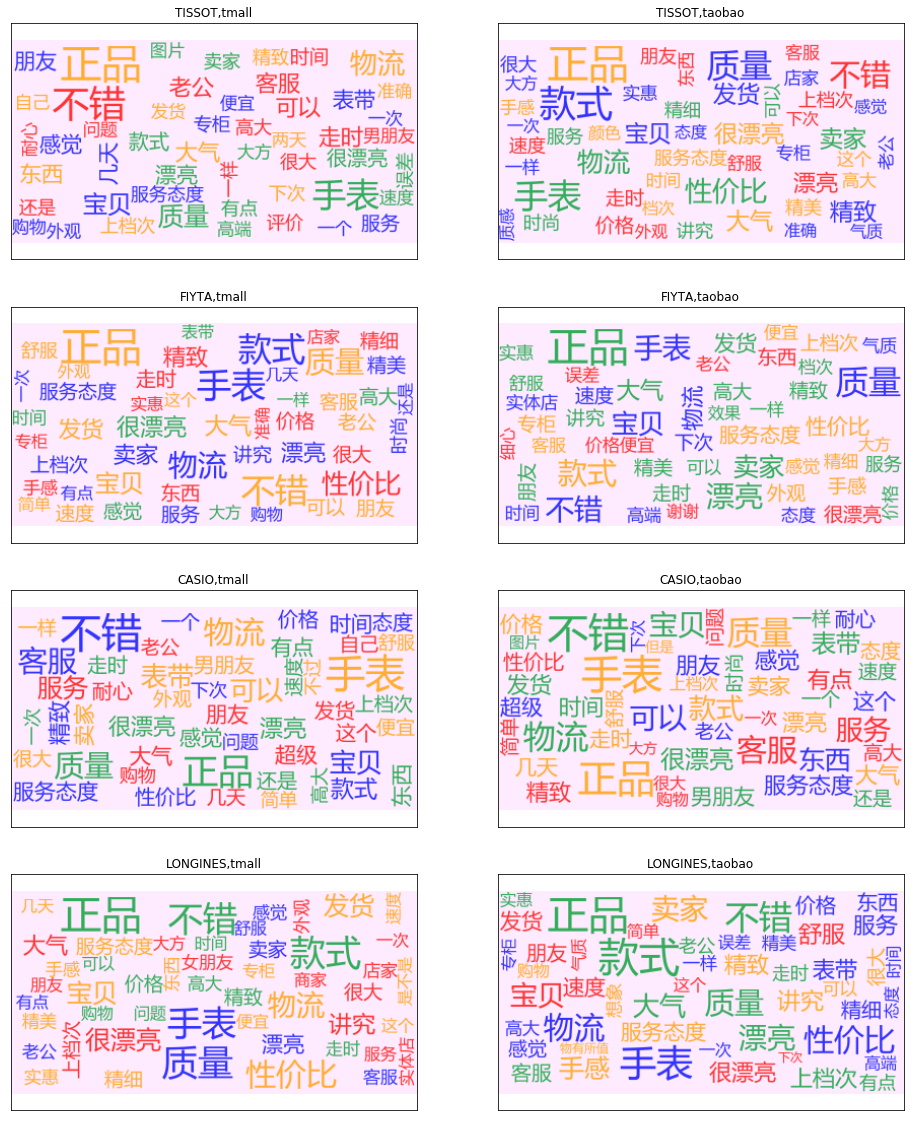

In [38]:
# 词云
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.misc import imread
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import random
# from wordcloud_cn import WordCloud_CN

def grey_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return random.choice(["#0000ff","red","#009933","#ff9900"]) #("hsl(230,100%%, %d%%)" % np.random.randint(49,51))

def show_wc(brand,platform,ax):
    bidx = df_ec_reviews[(df_ec_reviews.brand==brand) & (df_ec_reviews.platform==platform) & (df_ec_reviews.index<df_words.shape[0])].index
#     print(bidx)
    a=df_words.iloc[bidx].sum(axis=0)
    a.index=df_words.iloc[bidx].columns
    bdict = a[a>0].to_dict()
    
    wc_fname = "%s.png"%('md_ads')
    wc = WordCloud(font_path='msyh.ttf',
                    background_color="#ffe6ff", max_words=50,
                    max_font_size=40, random_state=42)

    wc.generate_from_frequencies(bdict)
    
    fig = ax.imshow(wc.recolor(color_func=grey_color_func, random_state=3),
           interpolation="bilinear",alpha=.8)
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    ax.set_title('%s,%s' % (brand,platform))
    
fig, axs = plt.subplots(nrows=4,ncols=2, sharex=True, figsize=(16, 20))    

for i,brand in enumerate(df_ec_reviews.brand.unique()):
    for j,platform in enumerate(df_ec_reviews.platform.unique()):
        show_wc(brand,platform,axs[i,j])